<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" alt="UdeA" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">MODELO DE REDES NEURONALES CONVOLUCIONALES PARA UN SISTEMA DE CLASIFICACIÓN CON IMÁGENES DE RESONANCIA MAGNÉTICA </strong><br><br> <span style="font-size: 30px;"> Luisa Fernanda Alzate Cuartas <br> Juan Camilo Henao Caro<br>Isabella Mendez Hoyos<br> Fernando Antonio Piñeres Ramos </span> </td> </tr> </table>

#### IMPORTE E INSTALACIÓN DE LIBRERÍAS

In [1]:
# Conectar con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Instalación de librerías.
!pip install optuna #Para optimizar hiperparámetros de modelos de aprendizaje automático y otros modelos.

In [3]:
import sys #Interactuar de manera directa con el intérprete de Python
import os #Se utiliza para interactuar con el sistema operativo
path = '/content/drive/MyDrive/operaciones' # Configura el entorno para trabajar con archivos en Google Drive
sys.path.append(path) # Permite importar módulos desde esta ruta.
os.chdir(path) # Cambia el directorio de trabajo actual

In [4]:
!ls /content/drive/MyDrive/operaciones/

a_preprocesamiento.ipynb     best_modelo_hiperparametros.keras	__pycache__
best_model.keras	     b_modelo.ipynb			README.md
best_model_l2_dropout.keras  funciones.py			salidas


In [5]:
# Importe de librerías.
import optuna #Para el ajuste de hiperparámetros.
import numpy as np  #Manipulación de estructuras de datos matriciales y funciones matemáticas de alto nivel.
import pandas as pd #Manipulación y transformación de datos.
import tensorflow as tf # Permite crear y entrenar redes neuronales, procesar datos y gestionar modelos para diversas aplicaciones.
from sklearn import metrics #. Funciones de puntuación, métricas de rendimiento, métricas por pares y cálculos de distancia.
from sklearn.metrics import roc_auc_score #Calcular el área bajo la curva característica operativa del receptor (ROC AUC) a partir de los puntajes de predicción.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Permite expandir los datos de entrenamiento de la imagen, mediante el uso de transformaciones como rotaciones aleatorias, transformaciones de corte, cambios, zooms y giros, en los datos de imagen disponibles.
from tensorflow.keras.models import Sequential #Apropiado para una pila simple de capas donde cada capa tiene exactamente un tensor de entrada y un tensor de salida .
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization #Para construir una red neuronal convolucional compleja que pueda procesar y aprender de datos de imágenes, textos secuenciales, o cualquier otro dato que pueda ser representado en una cuadrícula 2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ### Importación de Callbacks para el Control del Entrenamiento
#Los Callbacks son herramientas poderosas que nos permiten monitorear y controlar el proceso de entrenamiento del modelo, ayudando a optimizar el rendimiento y la eficiencia.
from sklearn.utils import shuffle #´Para que el modelo no aprenda de un orden específico y para asegurar que el entrenamiento sea más robusto.
import joblib #Para guardar y cargar modelos de machine learning.
#Guardar el modelo una vez entrenado para no tener que entrenarlo de nuevo cada vez que lo necesites usar.
import random
from tensorflow.keras.utils import to_categorical
from funciones import balance_datasets, make_gradcam_heatmap, superimpose_heatmap, show_images_with_gradcam

#### LECTURA DEL CONJUNTO DE IMÁGENES

In [6]:
#Cargar el conjunto de datos(imágenes) a usar para el modelo.
x_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_train.pkl') # Datos(imágenes) para el entrenamiento del modelo.
y_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_train.pkl') # Etiquetas para el entrenamiento del modelo.
x_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_test.pkl') # Datos(imágenes) para la validación del modelo.
y_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_test.pkl') # Etiquetas para el testeo del modelo.
x_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_val.pkl') # Datos(imágenes) para la validación del modelo.
y_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_val.pkl') # Etiquetas para la validación del modelo.

#### EXPLORACIÓN DEL CONJUNTO DE DATOS(IMÁGENES)

In [7]:
#Verificación de las Dimensiones de los Datos
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)
display(x_val.shape)
display(y_val.shape)

(5553, 160, 160, 3)

(5553,)

(695, 160, 160, 3)

(695,)

(694, 160, 160, 3)

(694,)

`Esto nos asegura que las imágenes y sus etiquetas tienen el formato correcto para el modelo.`

In [8]:
#Cantidad de clases por conjunto.
x_train.shape
x_test.shape
x_val.shape

display(np.unique(y_train, return_counts=True)) # Conteo de las clases para el conjunto de datos(imágenes) para entrenamiento.
display(np.unique(y_test, return_counts=True)) #Conteo de clases para el conjunto de datos(imáganes) para testeo.
display(np.unique(y_val, return_counts=True)) #Conteo de clases para el conjunto de datos(imágenes) para validación, despliegue.

(array([0, 1, 2, 3]), array([1232, 1316, 1600, 1405]))

(array([0, 1, 2, 3]), array([154, 165, 200, 176]))

(array([0, 1, 2, 3]), array([154, 164, 200, 176]))

`De acuerdo a lo resultados anteriores, este es un problema de clasificación multiclase y aunque las clases no parecen muy desbalanceadas, para prevenir el sobreajuste y mejorar la robustez del modelo, hemos decido utilizar una técnica llamada aumentación de datos.`

#### PREPROCESAMIENTO:NORMALIZACIÓN DE LOS PÍXELES.

`Las imágenes suelen tener valores de píxel en el rango de 0 a 255, por lo tanto es necesario escalarlos para que queden en un rango de 0 a 1, optimizando el rendimiento y la estabilidad del entrenamiento de la red neuronal. `






```
# El proceso implica:
1.  Convertir el tipo de dato de los píxeles a `float32`.
2.  Dividir cada valor de píxel por el valor máximo posible (255).
```



In [9]:
# Convertir el tipo de dato de los píxeles a float32.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

# Verificación de el nuevo rango de valores de píxeles después de normalizar.
print(f"x_train: Min={x_train.min()}, Max={x_train.max()}")
print(f"x_test:  Min={x_test.min()}, Max={x_test.max()}")
print(f"x_val:   Min={x_val.min()}, Max={x_val.max()}")

x_train: Min=0.0, Max=255.0
x_test:  Min=0.0, Max=255.0
x_val:   Min=0.0, Max=255.0


In [10]:
# Escalar los valores de los píxeles al rango [0, 1].
x_train /= 255
x_test /= 255
x_val /= 255

# Verificación de el nuevo rango de valores de píxeles después de normalizar.
print(f"x_train: Min={x_train.min()}, Max={x_train.max()}")
print(f"x_test:  Min={x_test.min()}, Max={x_test.max()}")
print(f"x_val:   Min={x_val.min()}, Max={x_val.max()}")

x_train: Min=0.0, Max=1.0
x_test:  Min=0.0, Max=1.0
x_val:   Min=0.0, Max=1.0


`Las imágenes se cargaron con valores de píxel en el rango estándar de 0 a 255. Sin embargo, al normalizarlas (dividir por 255), se observó que el valor de píxel más alto presente en todos los conjuntos de datos era 1. Esto resultó en un rango normalizado de 0.0 a 0.00392(1/255). Esta característica es común en imágenes médicas, donde la información relevante a menudo se concentra en un rango de intensidad muy bajo.`

#### AUMENTACIÓN DE DATOS (DATA AUGMENTATION).

`La Aumentación de Datos es una técnica que consiste en crear nuevas muestras de datos de entrenamiento modificando ligeramente las existentes. En el contexto de imágenes, esto significa aplicar transformaciones aleatorias (como rotaciones, zooms, volteos, cambios de brillo, etc.) a las imágenes originales para generar versiones "nuevas" que el modelo pueda aprender.`

`No estamos añadiendo datos reales y únicos, sino expandiendo artificialmente la diversidad de nuestro conjunto de entrenamiento a partir de las imágenes ya disponibles.Cada vez que el modelo accede a una imagen original durante el entrenamiento, se genera una versión ligeramente diferente de la misma. De esta manera, el modelo nunca ve la misma imagen idéntica dos veces, lo que fuerza a aprender patrones más generales en lugar de memorizar ejemplos específicos.`

In [11]:
# Generador de augmentación
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest' #se rellena los pixeles vacios con el pixel mas cercano
)

In [12]:
# Aumentar el conjunto de entrenamiento.
x_train_balanced, y_train_balanced = balance_datasets(x_train, y_train, datagen)

`Aplicamos aumentación de datos únicamente al conjunto de entrenamiento, y mantenemos los datos de validación y prueba "puros" para evaluar al modelo.`

In [19]:
# Guardar los conjuntos balanceados.
joblib.dump(x_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/x_train_balanced.pkl')
joblib.dump(y_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/y_train_balanced.pkl')

['/content/drive/MyDrive/operaciones/salidas/data_final/y_train_balanced.pkl']

In [27]:
#Dimensiones de los datos(imágenes) balanceados.
display(x_train_balanced.shape,y_train_balanced.shape)
display(y_train_balanced = to_categorical(y_train_balanced, num_classes=4))

(6400, 160, 160, 3)

(6400, 4)

Después de aplicada la aumentación de datos, para el entrenamiento contamos con 6400 en total, es decir, 1600 imágenes por categoría: Glioma, Meningioma.

#### MODELO DE REDES NEURONALES CONVOLUSIONALES

##### MODELO BASE
---

In [ ]:
# =====================
# 2. MODELO FUNCIONAL CNN
# =====================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


inputs = tf.keras.Input(shape=x_train_balanced.shape[1:])
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='last_conv')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# =====================
# 3. COMPILACIÓN
# =====================
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['AUC']
)

cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,962,724 (11.30 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=3,
    mode='max',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

history = cnn_model.fit(
    x_train_balanced, y_train_balanced,
    validation_data=(x_test_balanced, y_test_balanced),
    epochs=15,
    callbacks=[early_stopping, model_checkpoint],
    batch_size=100
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7837 - loss: 1.0609
Epoch 1: val_AUC improved from -inf to 0.93865, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - AUC: 0.7853 - loss: 1.0568 - val_AUC: 0.9386 - val_loss: 0.5928
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9669 - loss: 0.4352
Epoch 2: val_AUC improved from 0.93865 to 0.96343, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - AUC: 0.9670 - loss: 0.4348 - val_AUC: 0.9634 - val_loss: 0.4509
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9827 - loss: 0.3109
Epoch 3: val_AUC improved from 0.96343 to 0.96800, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - AUC: 0.9827 - loss: 0.3108 - val_AUC: 0.9680 - val_loss: 0.4300
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9879 - loss: 0.2574
Epoch 4: val_AUC improved from 0.96800 to 0.97133, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/st

In [ ]:
import matplotlib.pyplot as plt

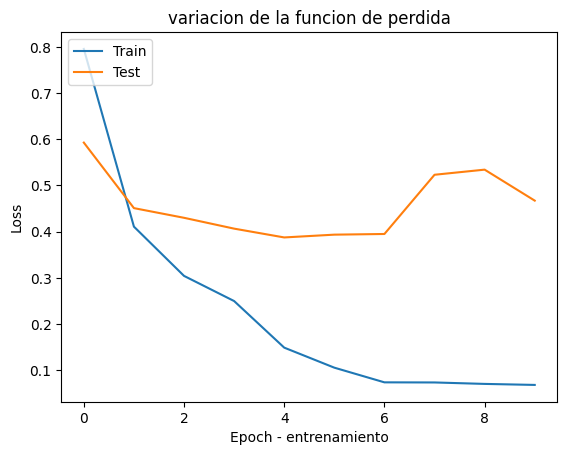

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('variacion de la funcion de perdida')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

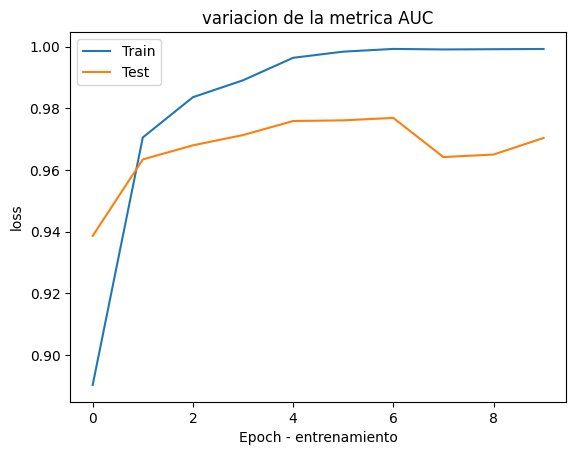

In [ ]:
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('variacion de la metrica AUC')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### XAI
---



Este bloque de código implementa Grad-CAM (Gradient-weighted Class Activation Mapping), una técnica de
Inteligencia Artificial Explicable (XAI) utilizada para modelos de visión por computador, como redes neuronales
convolucionales (CNN). Grad-CAM genera un mapa de calor (heatmap) que resalta las regiones de una imagen
que más influyen en la predicción del modelo. Esto permite visualizar "dónde está mirando" la red neuronal
cuando clasifica una imagen, lo cual es especialmente útil en contextos como el diagnóstico médico, donde es
importante entender y confiar en la decisión automática. Al superponer el heatmap sobre la imagen original,
obtenemos una explicación visual de la predicción, lo que convierte este enfoque en una herramienta poderosa
para interpretar modelos de aprendizaje profundo.






In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Definir las clases que tienes
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Función para generar Grad-CAM (supongo que ya la tienes, si no puedo ayudarte a armarla)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Función para superponer heatmap a la imagen
def superimpose_heatmap(img, heatmap, alpha=0.4):
    import cv2
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

# Ejemplo para mostrar imágenes y predicciones con Grad-CAM
def show_images_with_gradcam(model, dataset, start_idx, end_idx, last_conv_layer_name):
    for i in range(start_idx, end_idx):
        img = dataset[i]
        img_array = np.expand_dims(img, axis=0)  # Expandir dims para batch
        preds = model.predict(img_array)
        pred_class = np.argmax(preds[0])
        pred_label = class_names[pred_class]

        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class)
        img_uint8 = (img * 255).astype(np.uint8)  # Si tu imagen está en [0,1]
        superimposed_img = superimpose_heatmap(img_uint8, heatmap)

        plt.figure(figsize=(10,4))

        plt.subplot(1, 3, 1)
        plt.title('Imagen Original')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Heatmap Grad-CAM')
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title(f'Imagen + Heatmap\nPredicción: {pred_label}')
        plt.imshow(superimposed_img)
        plt.axis('off')

        plt.show()

# Usar la función (por ejemplo para imágenes de índice 8 a 12)
show_images_with_gradcam(cnn_model, x_test_balanced, 80, 95, last_conv_layer_name='conv2d')


##### MODELO CNN CON REGULARIZACION
---

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import random
import os

# ---------- SEMILLA PARA REPRODUCIBILIDAD ----------
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# ---------- HIPERPARÁMETROS ----------
reg_strength = 0.001
dropout_rate = 0.1
input_shape = x_train_balanced.shape[1:]

# ---------- MODELO FUNCIONAL CON L2 + DROPOUT ----------
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(reg_strength))(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(reg_strength))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=regularizers.l2(reg_strength))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

cnn_model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# ---------- COMPILACIÓN ----------
cnn_model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.AUC(name='AUC')]
)

cnn_model2.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,962,724 (11.30 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# ---------- CHECKPOINT ----------

from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=3,
    mode='max',
    restore_best_weights=True
)



checkpoint2 = ModelCheckpoint(
    filepath='best_model_l2_dropout.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

# ---------- ENTRENAMIENTO ----------
history2 = cnn_model2.fit(
    x_train_balanced, y_train_balanced,
    batch_size=100,
    epochs=7,
    validation_data=(x_test_balanced, y_test_balanced),
    callbacks=[checkpoint2,early_stopping]
)

Epoch 1/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7617 - loss: 1.2672
Epoch 1: val_AUC improved from -inf to 0.93553, saving model to best_model_l2_dropout.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - AUC: 0.7633 - loss: 1.2633 - val_AUC: 0.9355 - val_loss: 0.7465
Epoch 2/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9416 - loss: 0.7006
Epoch 2: val_AUC improved from 0.93553 to 0.96125, saving model to best_model_l2_dropout.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - AUC: 0.9417 - loss: 0.7001 - val_AUC: 0.9613 - val_loss: 0.5984
Epoch 3/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9660 - loss: 0.5616
Epoch 3: val_AUC improved from 0.96125 to 0.96840, saving model to best_model_l2_dropout.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - AUC: 0.9661 - loss: 0.5614 - val_AUC: 0.9684 - val_loss: 0.5510
Epoch 4/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9764 - loss: 0.4910
Epoch 4: val_AUC improved from 0.96840 to 0.97360, saving model to best_model_l2_dropout.ker

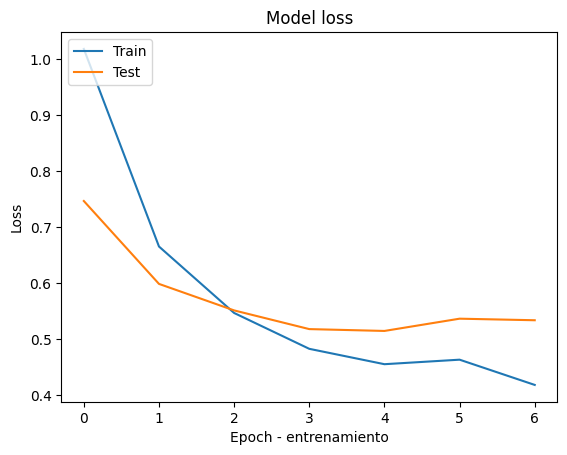

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


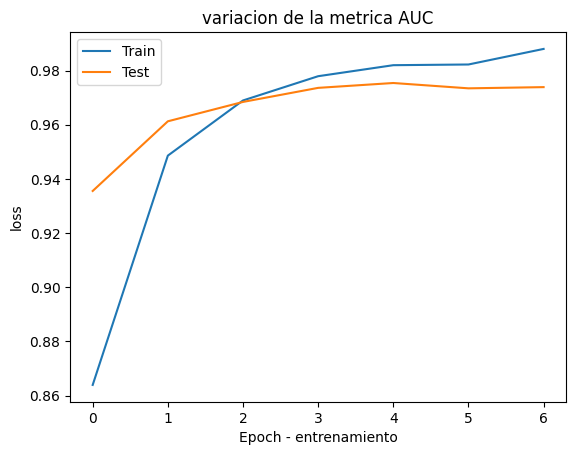

In [ ]:
plt.plot(history2.history['AUC'])
plt.plot(history2.history['val_AUC'])
plt.title('variacion de la metrica AUC')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### MODELO CON AJUSTES DE HIPERPARAMETROS
---

In [ ]:
# Función objetivo para utilizar Optuna con API funcional
def objective(trial):
    # Hiperparámetros
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2, step=0.05)
    reg_strength = trial.suggest_float('reg_strength', 0.0001, 0.0005, step=0.0001)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Modelo funcional CNN
    inputs = tf.keras.Input(shape=x_train_balanced.shape[1:])
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength))(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength),
                               name='last_conv')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(reg_strength))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Optimizador
    opt = tf.keras.optimizers.Adam(learning_rate=0.001) if optimizer_name == 'adam' else tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compilar
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Callback

    early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=3,
    mode='max',
    restore_best_weights=True
)


    checkpoint3 = ModelCheckpoint(
        filepath='best_modelo_hiperparametros.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Entrenamiento
    history3 = model.fit(
        x_train_balanced, y_train_balanced,
        epochs=10,
        validation_data=(x_test_balanced, y_test_balanced),
        batch_size=100,
        verbose=0,
        callbacks=[checkpoint3, early_stopping]
    )

    # Cargar mejor modelo
    model_win = tf.keras.models.load_model('best_modelo_hiperparametros.keras')

    # Evaluación
    y_pred_prob = model_win.predict(x_test_balanced)
    auc = roc_auc_score(y_test_balanced, y_pred_prob)
    trial.set_user_attr("model", model_win)

    return auc

  # Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

# Final evaluation
test_loss, test_auc = best_model.evaluate(x_test_balanced, y_test_balanced)
print(f"\Mejor AUC on test set: {test_auc:.4f}")
best_model.summary()


[I 2025-06-08 08:31:44,285] A new study created in memory with name: no-name-75bb18b7-e462-4cb3-b130-c8fe96ba3df4



Epoch 1: val_auc improved from -inf to 0.93858, saving model to best_modelo_hiperparametros.keras


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_AUC` which is not available. Available metrics are: auc,loss,val_auc,val_loss
  current = self.get_monitor_value(logs)



Epoch 2: val_auc improved from 0.93858 to 0.96444, saving model to best_modelo_hiperparametros.keras

Epoch 3: val_auc improved from 0.96444 to 0.97016, saving model to best_modelo_hiperparametros.keras

Epoch 4: val_auc improved from 0.97016 to 0.97146, saving model to best_modelo_hiperparametros.keras

Epoch 5: val_auc improved from 0.97146 to 0.97291, saving model to best_modelo_hiperparametros.keras

Epoch 6: val_auc did not improve from 0.97291

Epoch 7: val_auc did not improve from 0.97291

Epoch 8: val_auc improved from 0.97291 to 0.97387, saving model to best_modelo_hiperparametros.keras

Epoch 9: val_auc did not improve from 0.97387

Epoch 10: val_auc did not improve from 0.97387
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step


[I 2025-06-08 09:04:46,621] Trial 0 finished with value: 0.9747125000000001 and parameters: {'dropout_rate': 0.05, 'reg_strength': 0.0001, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9747125000000001.


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - auc: 0.9730 - loss: 0.4916
\Mejor AUC on test set: 0.9739


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,888,174 (33.91 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,925,450 (22.60 MB)

In [ ]:
modelo_ganador=tf.keras.models.load_model('best_modelo_hiperparametros.keras')
test_loss, test_auc = modelo_ganador.evaluate(x_test_balanced, y_test_balanced)
print(f"\Mejor AUC on test set: {test_auc:.4f}")



25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - auc: 0.9730 - loss: 0.4916
\Mejor AUC on test set: 0.9739


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step


Text(0.5, 1.0, 'probabilidades imágenes en entrenamiento')

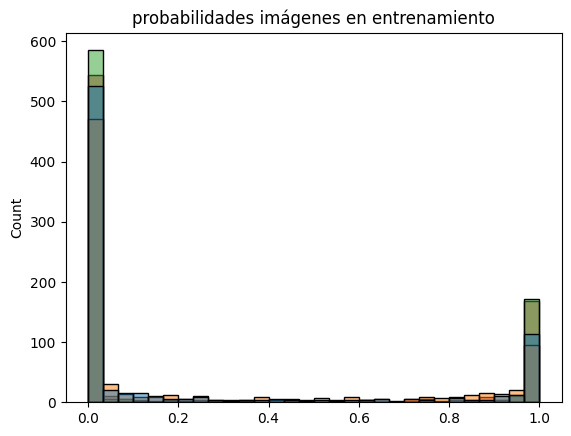

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

####probabilidades en evaluación para grupo 1 (tienen neumonía) #######
prob=modelo_ganador.predict(x_test_balanced)
sns.histplot(prob, legend=False, bins=30)
plt.title("probabilidades imágenes en entrenamiento")### conocer el comportamiento de las probabilidades para revisar threshold


200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step


Text(0.5, 1.0, 'probabilidades imágenes en entrenamiento')

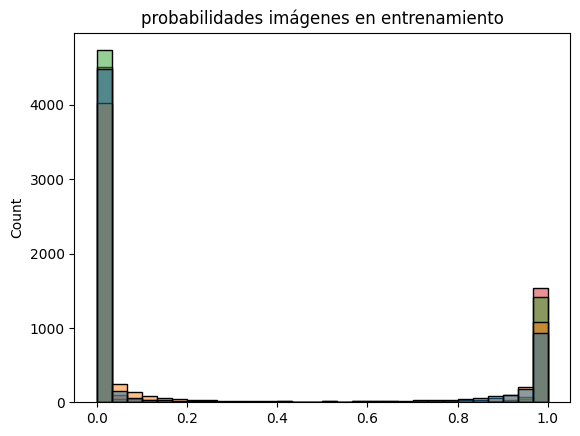

In [ ]:
### probabilidades en entrenamiento #####
prob=modelo_ganador.predict(x_train_balanced)
sns.histplot(prob, legend=False, bins=30)
plt.title("probabilidades imágenes en entrenamiento")### conocer el comportamiento de las probabilidades para revisar threshold


200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98      1600
  meningioma       0.97      0.99      0.98      1600
   pituitary       1.00      1.00      1.00      1600
     notumor       0.99      1.00      0.99      1600

    accuracy                           0.99      6400
   macro avg       0.99      0.99      0.99      6400
weighted avg       0.99      0.99      0.99      6400

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step
              precision    recall  f1-score   support

      glioma       0.92      0.80      0.86       200
  meningioma       0.77      0.84      0.81       200
   pituitary       0.96      0.94      0.95       200
     notumor       0.86      0.92      0.89       200

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



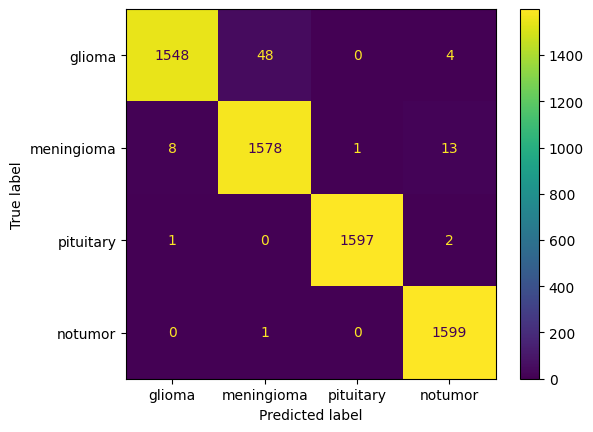

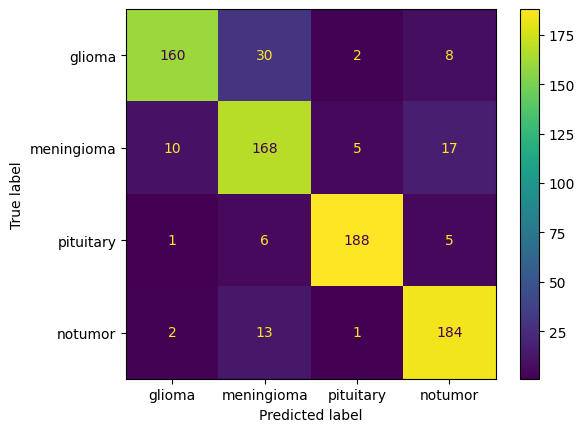

In [ ]:
import numpy as np
from sklearn import metrics

# --- TRAIN ---
# Obtener predicciones de clase (no usar threshold)
pred_train_prob = modelo_ganador.predict(x_train_balanced)
pred_train = np.argmax(pred_train_prob, axis=1)
y_train_true = np.argmax(y_train_balanced, axis=1)  # si está one-hot encoded

# Reporte de métricas y matriz de confusión
print(metrics.classification_report(y_train_true, pred_train, target_names=['glioma', 'meningioma', 'pituitary', 'notumor']))
cm = metrics.confusion_matrix(y_train_true, pred_train, labels=[0, 1, 2, 3])
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['glioma', 'meningioma', 'pituitary', 'notumor'])
disp.plot()

# --- TEST ---
pred_test_prob = modelo_ganador.predict(x_test_balanced)
pred_test = np.argmax(pred_test_prob, axis=1)
y_test_true = np.argmax(y_test_balanced, axis=1)  # si está one-hot encoded

print(metrics.classification_report(y_test_true, pred_test, target_names=['glioma', 'meningioma', 'pituitary', 'notumor']))
cm = metrics.confusion_matrix(y_test_true, pred_test, labels=[0, 1, 2, 3])
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['glioma', 'meningioma', 'pituitary', 'notumor'])
disp.plot()
